In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE



Fonte dos dados: https://www.kaggle.com/datasets/ealaxi/paysim1/data <br><br>
**Observação importante: Transações que forem detectadas como fraude seram canceladas, portanto para detecção de fraudes as colunas oldbalanceOrig, newbalanceOrg, oldbalanceDest e newbalanceDest não devem ser utilizadas no treinamento do modelo.**<br><br>
Créditos: E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

###Ingestão dos dados

In [ ]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df = df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)
df.head()

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0,0
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0,0
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0,0


In [ ]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df.head(5)

,step,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,M1979787155,0,0,False,False,True,False
1,1,1864.28,C1666544295,M2044282225,0,0,False,False,True,False
2,1,181.00,C1305486145,C553264065,1,0,False,False,False,True
3,1,181.00,C840083671,C38997010,1,0,True,False,False,False
4,1,11668.14,C2048537720,M1230701703,0,0,False,False,True,False


In [ ]:
print(df['nameOrig'].nunique())
print(df['nameOrig'].size)

6353307
6362620


In [ ]:
frequency_nameOrig = df['nameOrig'].value_counts()
df['nameOrig'] = df['nameOrig'].map(frequency_nameOrig)

frequency_nameDest = df['nameDest'].value_counts()
df['nameDest'] = df['nameDest'].map(frequency_nameDest)

In [ ]:
print(df.head())
print(df['nameOrig'].nunique())
print(df['nameOrig'].size)

   step    amount  nameOrig  nameDest  isFraud  isFlaggedFraud  type_CASH_OUT  \
0     1   9839.64         1         1        0               0          False   
1     1   1864.28         1         1        0               0          False   
2     1    181.00         1        44        1               0          False   
3     1    181.00         1        41        1               0           True   
4     1  11668.14         1         1        0               0          False   

   type_DEBIT  type_PAYMENT  type_TRANSFER  
0       False          True          False  
1       False          True          False  
2       False         False           True  
3       False         False          False  
4       False          True          False  
3
6362620


In [ ]:
df['step'] = df['step'].astype(int)
df['amount'] = df['amount'].astype(float)
df['nameOrig'] = df['nameOrig'].astype(int)
df['nameDest'] = df['nameDest'].astype(int)
df['isFraud'] = df['isFraud'].astype(int)
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype(int)
df['type_CASH_OUT'] = df['type_CASH_OUT'].astype('uint8')
df['type_DEBIT'] = df['type_DEBIT'].astype('uint8')
df['type_PAYMENT'] = df['type_PAYMENT'].astype('uint8')
df['type_TRANSFER'] = df['type_TRANSFER'].astype('uint8')

### Funções para visualização do resultado

In [ ]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss do modelo')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy do modelo')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

###Preparação dos dados / oversampling

In [ ]:
df_sampled = df.sample(frac=0.01, random_state=42)

X = df_sampled.drop('isFraud', axis=1)
y = df_sampled['isFraud']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['isFraud'] = y_resampled

train, test= train_test_split(df_resampled, test_size=0.4, random_state=42)

val, test = train_test_split(test, test_size=0.5, random_state=42)

In [ ]:
def get_labels(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if not x_labels:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X,y))

  return data, X, y

In [ ]:
x_labels = df.columns.drop("isFraud").tolist()
_,X_train_fraud, y_train_fraud = get_labels(train, "isFraud",x_labels)
_,X_val_fraud, y_val_fraud = get_labels(val, "isFraud",x_labels)
_,X_test_fraud, y_test_fraud = get_labels(test, "isFraud",x_labels)

In [ ]:
print(df['isFraud'].value_counts())
print(df_resampled['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFraud
0    63539
1    63539
Name: count, dtype: int64


###Criação do modelo

In [ ]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu',input_shape=(9,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="binary_crossentropy",metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


###Treinamento do modelo

In [ ]:
history = nn_model.fit(
    X_train_fraud, y_train_fraud, epochs=100, batch_size=32, validation_data=(X_val_fraud,y_val_fraud), verbose=0
)

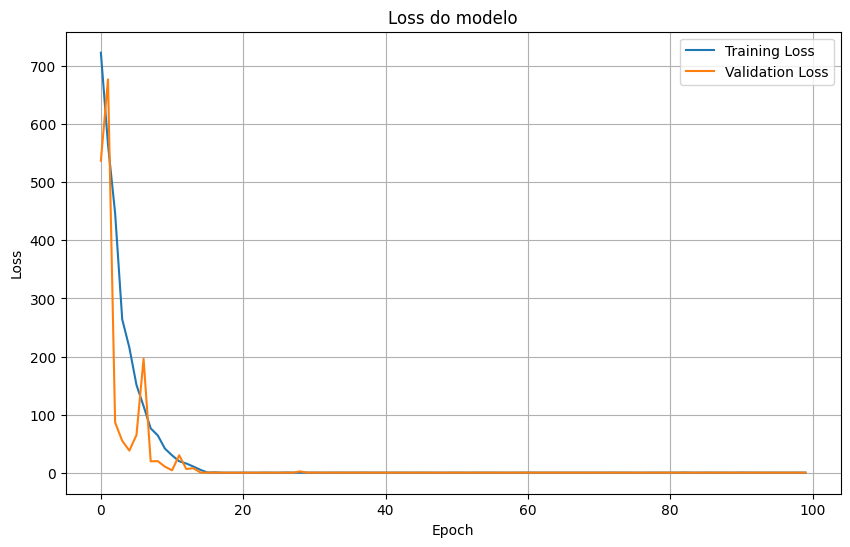

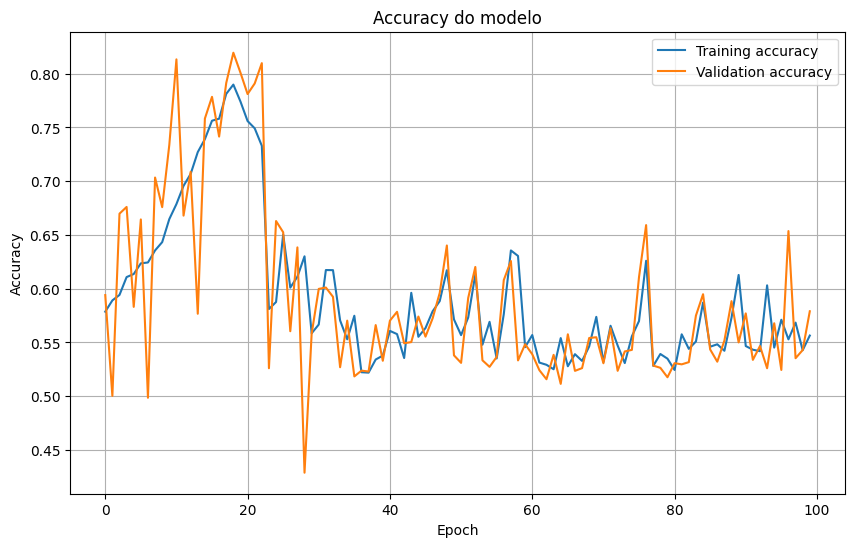

In [ ]:
plot_loss(history)
plot_accuracy(history)

In [ ]:
print(history.history)

{'accuracy': [0.5786270499229431, 0.5890932083129883, 0.5941951274871826, 0.610799252986908, 0.6136322021484375, 0.6235737204551697, 0.6243868470191956, 0.6356005668640137, 0.6432993412017822, 0.6647299528121948, 0.6786847710609436, 0.6956692934036255, 0.7067387104034424, 0.7270545363426208, 0.739107608795166, 0.7562363743782043, 0.7581118941307068, 0.781221330165863, 0.7898381352424622, 0.7740602493286133, 0.7559347152709961, 0.7491671442985535, 0.7329040169715881, 0.5810796618461609, 0.5876242518424988, 0.6503947973251343, 0.6009889245033264, 0.6111533641815186, 0.6301183104515076, 0.5585079789161682, 0.5666788816452026, 0.6173438429832458, 0.6172520518302917, 0.5705217123031616, 0.5528945922851562, 0.5748367309570312, 0.5222962498664856, 0.5219159126281738, 0.5341132879257202, 0.5377724766731262, 0.5607507228851318, 0.5577604174613953, 0.5355035066604614, 0.5961493253707886, 0.5552684664726257, 0.5633869171142578, 0.578941822052002, 0.5884767770767212, 0.6171864867210388, 0.57142668

In [ ]:
print(history.history['val_accuracy'])

[0.594035267829895, 0.5003147721290588, 0.6697749495506287, 0.6760308742523193, 0.5830972790718079, 0.6644240021705627, 0.49854421615600586, 0.7033758163452148, 0.6758341193199158, 0.7337504029273987, 0.8133065700531006, 0.6679650545120239, 0.708687424659729, 0.5766839981079102, 0.7582625150680542, 0.7784466743469238, 0.7415013909339905, 0.7913519144058228, 0.8194838166236877, 0.8008734583854675, 0.7810434103012085, 0.7908797860145569, 0.8098048567771912, 0.5260072350502014, 0.6629288792610168, 0.6525023579597473, 0.5604344010353088, 0.6384167671203613, 0.42882436513900757, 0.5580343008041382, 0.599819004535675, 0.6010780334472656, 0.5924220681190491, 0.5269515514373779, 0.5702707171440125, 0.5184136033058167, 0.5237645506858826, 0.5229383111000061, 0.5661787986755371, 0.5329319834709167, 0.5702707171440125, 0.5784938335418701, 0.5492603182792664, 0.5503226518630981, 0.5740872025489807, 0.555398166179657, 0.5723559856414795, 0.5961205363273621, 0.6401872634887695, 0.5380075573921204, 0